In [7]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html
import os
import sys

import pandas as pd
import numpy as np
import pickle
from datetime import date, datetime, timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb

import boto3
import logging 

logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
logger.info(f'Starting Notebook')

# !pip install "jupyterlab>=3" "ipywidgets>=7.6" --user
# !pip install jupyter-dash --user
# !jupyter lab build --user

# !pip install snowflake --user
# !pip install snowflake-connector-python --user
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

INFO:root:Starting Notebook
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.


In [3]:
from io import StringIO
class Utils():
    @staticmethod
    def to_csv_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {bucket}/{key}')
    
    @staticmethod
    def to_pkl_s3(content, bucket, key_path, filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {bucket}/{key}')

    @staticmethod
    def read_csv_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'], na_values="\\N")
        logger.info(f'Read from {bucket}/{key}')
        return df
        
    @staticmethod
    def read_pkl_s3(bucket, key_path,filename):
        client = boto3.client('s3')
        key = os.path.join(key_path, filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {bucket}/{key}')
        return model



## Trailer drop date

In [229]:
def run_query(querystr, ctx):
    cursor_list = ctx.execute_string(
        querystr
        )
    df = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
    df.columns= df.columns.str.lower()
    
    return df
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

querystr='''
select 
    * 
from max_dev.workspace.forecasting_premieres 
where premiere_date>='2022-05-08' 
and premiere_date<'2023-01-01' 
'''

df_trailer = run_query(querystr, ctx)
df_trailer.loc[(df_trailer.title_name=='THE NEVERS') & (df_trailer.premiere_date=='2022-10-03'), 'season_number'] = 2
df_trailer.loc[(df_trailer.title_name=='THE NEVERS') & (df_trailer.premiere_date=='2022-11-28'), 'season_number'] = 3
df_trailer['season_number'] = df_trailer['season_number'].astype('int')
df_trailer.head()

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.4, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.cursor:query: [select * from max_dev.workspace.forecasting_premieres where premiere_date>='2022...]
INFO:snowflake.connector.cursor:query execution done


,f_id,title_id,imdb_id,season_number,trailer_date,premiere_date,title_name,content_category
0,z202201lg,,z202201lg,1,None,2022-09-08,LIZZO: GOOD AS HELL,series
1,tt11212198,,tt11212198,1,None,2022-07-21,RAP SH*T,series
2,tt8783930,,tt8783930,1,2022-04-21,2022-05-15,THE TIME TRAVELER'S WIFE,series
3,tt11468254,,tt11468254,1,None,2022-09-11,WHITE HOUSE PLUMBERS,series
4,tt11815682,GYIBToQrPdotpNQEAAAEa,tt11815682,2,2022-04-26,2022-05-12,HACKS,series


## Marketing

In [209]:
key_path = 'psi_first_views/dev'
input_bucket="hbo-ingest-datascience-content-dev"

df_mkt = Utils.read_csv_s3(input_bucket, key_path, f'marketing_fv_20220508.csv') 
df_mkt = df_mkt.dropna()

## data cleaning 
df_mkt.columns= df_mkt.columns.str.lower()
df_mkt = df_mkt.rename(columns={'days after premiere':'days_since_premiere', 'first views':'first_views'})
df_mkt = df_mkt.astype({'first_views':float})
df_mkt['premiere_date'] = pd.to_datetime(df_mkt['premiere_date']).dt.date
df_mkt['premiere_date'] = pd.to_datetime(df_mkt['premiere_date'])
df_mkt = df_mkt[df_mkt.title_name.str.isupper()]
df_mkt['title_name'] = df_mkt['title_name'].str.title()

df_mkt = df_mkt[['title_name', 'imdb_id',  'premiere_date', 'date',
       'season_number', 'content_category', 'days_since_premiere','first_views',]]

df_mkt_grp = df_mkt.groupby(by=['title_name','season_number','content_category']).max().reset_index()
non_ninety_titles = df_mkt_grp[df_mkt_grp.days_since_premiere<=88].title_name.unique().tolist()
df_mkt = df_mkt[~df_mkt.title_name.isin(non_ninety_titles)]
df_mkt.title_name.nunique()
df_mkt = df_mkt.drop_duplicates(subset=['title_name','season_number','content_category','days_since_premiere'], keep='last')

## Munge data
df_mkt_title = df_mkt.groupby(by=['title_name','imdb_id','premiere_date','season_number','content_category']).agg({'days_since_premiere':'max', 'first_views':'sum'}).reset_index()
df_mkt_title = df_mkt_title[(df_mkt_title.premiere_date>='2022-05-08')]
print(df_mkt_title.shape)
df_mkt_title.sort_values(by='premiere_date')

df_mkt_title.loc[(df_mkt_title.title_name=='The Nevers') & (df_mkt_title.premiere_date=='2022-10-03'), 'season_number'] = 2
df_mkt_title.loc[(df_mkt_title.title_name=='The Nevers') & (df_mkt_title.premiere_date=='2022-11-28'), 'season_number'] = 3
df_mkt_title.season_number = df_mkt_title.season_number.astype(int)

df_mkt_title.loc[(df_mkt_title.title_name=='The Nevers') & (df_mkt_title.premiere_date=='2022-10-03'), 'season_number'] = 2
df_mkt_title.loc[(df_mkt_title.title_name=='The Nevers') & (df_mkt_title.premiere_date=='2022-11-28'), 'season_number'] = 3
df_mkt_title.season_number = df_mkt_title.season_number.astype(int)

    

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/marketing_fv_20220508.csv


(38, 7)


,title_name,imdb_id,premiere_date,season_number,content_category,days_since_premiere,first_views
15,Hacks,tt11815682,2022-05-12,2.0,series,89.0,17497.58
38,The Time Traveler'S Wife,tt8783930,2022-05-15,1.0,series,89.0,24854.82
11,Fantastic Beasts 3,tt4123432,2022-05-30,1.0,pay1,89.0,112255.35
12,Father Of The Bride,tt13249596,2022-06-16,1.0,movie,89.0,96189.37
41,Westworld,tt0475784,2022-06-26,4.0,series,89.0,91850.75
24,Pretty Little Liars: Original Sin,tt13075042,2022-07-07,1.0,series,89.0,91850.75
25,Rap Sh*T,tt11212198,2022-07-21,1.0,series,89.0,25906.53
16,Harley Quinn,tt7658402,2022-07-28,3.0,series,89.0,9185.08
18,House Party,tt8005118,2022-07-28,1.0,movie,89.0,102042.34
9,Elvis,tt3704428,2022-08-08,1.0,pay1,89.0,56127.64


## PSI

In [126]:
key_path = 'psi_first_views/dev'
input_bucket="hbo-ingest-datascience-content-dev"

df_psi = []
date = ['2022-05-01']
for i in date:
    df_temp = Utils.read_csv_s3(input_bucket, key_path, f'psi_daily_xgb_forecast_{i}.csv') 
    df_temp['effective_start_date'] = pd.to_datetime(df_temp['effective_start_date'])
    date_min = datetime.strptime(i, '%Y-%m-%d')
#     date_max = date_min + timedelta(days=60)
    df_temp = df_temp[(df_temp.effective_start_date>='2022-05-08') & (df_temp.effective_start_date<'2023-01-01')]
    df_temp['imdb_id'] = df_temp['imdb_imdb_series_id']
    df_temp['imdb_id'] = df_temp['imdb_id'].fillna(0)
    df_temp = df_temp.drop_duplicates(subset=['title_name','season_number','category','request_date'])
    df_psi.append(df_temp)

col = ['imdb_id','title_name','season_number', 'effective_start_date',
       'tier',  'tier_adj', 'content_category','category', 'prequel_count', 'prequel_featured_count', 
      'pred_date', 'first_views_pred_decay',]

df_psi = pd.concat(df_psi)
df_psi = df_psi[col].groupby(by=col[:-1]).sum().reset_index()
df_psi.loc[df_psi.season_number==0, 'season_number'] = 1
df_psi['title_name'] = df_psi['title_name'].str.title()
df_psi.season_number = df_psi.season_number.astype(int)

dic = {'Father Of The Bride':'tt13249596', 'Lizzo Concert Doc':'z202212lizz', 'Lizzo: Good As Hell':'z202201lg', 
       'A Christmas Story Christmas': 'z202211csc', 'A Hollywood Christmas': 'z202212hc', "Santa'S Stolen Jingle Bells":'z202212ssjb',
      "Salem'S Lot": 'tt10245072', "Scoob! Holiday Haunt":'z202210sh', 'Shaq':'z202211sh',
      "Magic Mike'S Last Dance":'z202208mm3'}
for key in dic.keys():
    df_psi.loc[df_psi.title_name==key, 'imdb_id'] = dic[key]

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
INFO:root:Read from hbo-ingest-datascience-content-dev/psi_first_views/dev/psi_daily_xgb_forecast_2022-05-01.csv


## Comparison

In [232]:
df_tot[df_tot.trailer_date.notnull()]

,title_name_x,imdb_id,premiere_date,season_number,content_category_x,days_since_premiere,first_views,title_name_y,effective_start_date,tier,tier_adj,content_category_y,category,prequel_count,prequel_featured_count,pred_date,first_views_pred_decay,trailer_date,first_views_mkt_scaled,first_views_psi
12,Hacks,tt11815682,2022-05-12,2,series,89.0,17497.58,Hacks,2022-05-19,2.0,2.0,series,Scripted Comedy Series,-1.0,-1.0,2022-05-01,17025.246094,2022-04-26,2.187198e+04,17025.246094
14,House Of The Dragon,tt11198330,2022-08-21,1,series,90.0,2820736.61,House Of The Dragon,2022-08-21,0.0,0.0,series,Scripted Drama Series,-1.0,-1.0,2022-05-01,491107.687500,2021-10-05,3.525921e+06,491107.687500
33,The Time Traveler'S Wife,tt8783930,2022-05-15,1,series,89.0,24854.82,The Time Traveler'S Wife,2022-05-15,2.0,2.0,series,Scripted Drama Series,-1.0,-1.0,2022-05-01,37819.886719,2022-04-21,3.106853e+04,37819.886719


In [230]:
df_tot_raw = df_mkt_title.merge(df_psi, on=['imdb_id','season_number'], how='outer').merge(df_trailer[['imdb_id','season_number','trailer_date']], on=['imdb_id','season_number'],how='left')
df_tot= df_tot_raw[(df_tot_raw.effective_start_date<='2023-01-01') & (df_tot_raw.tier<=2)]
df_tot['first_views_mkt_scaled'] = df_tot['first_views']*1.25
df_tot['first_views_psi'] = df_tot['first_views_pred_decay']
df_tot = df_tot.drop_duplicates(subset=['imdb_id','season_number','content_category_y'])
print(df_mkt_title.shape)
print(df_psi.shape)
print(df_tot.shape)
df_tot.isnull().sum()

(38, 7)
(143, 12)
(56, 20)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


title_name_x              24
imdb_id                    0
premiere_date             24
season_number              0
content_category_x        24
days_since_premiere       24
first_views               24
title_name_y               0
effective_start_date       0
tier                       0
tier_adj                   0
content_category_y         0
category                   0
prequel_count              0
prequel_featured_count     0
pred_date                  0
first_views_pred_decay     0
trailer_date              53
first_views_mkt_scaled    24
first_views_psi            0
dtype: int64

,title_name_x,imdb_id,season_number,effective_start_date,tier,category,trailer_date,first_views_mkt_scaled,first_views_psi
14,House Of The Dragon,tt11198330,1,2022-08-21,0.0,Scripted Drama Series,2021-10-05,3.525921e+06,491107.687500
0,A Christmas Story Christmas,z202211csc,1,2022-11-17,1.0,Scripted Features,NaN,3.366254e+04,155513.343750
21,Pretty Little Liars: Original Sin,tt13075042,1,2022-07-07,1.0,Scripted Drama Series,None,1.148134e+05,128220.304687
18,Magic Mike 3,z202208mm3,1,2022-10-27,1.0,Scripted Features,NaN,1.274010e+05,155513.343750
36,Westworld,tt0475784,4,2022-06-26,1.0,Scripted Drama Series,None,1.148134e+05,128220.304687
26,Sex Lives Of College Girls,tt11212276,2,2022-11-17,1.0,Scripted Comedy Series,None,5.742695e+04,66872.125000
28,Super Pets,tt8912936,1,2022-09-12,1.0,Pay 1 WB Theatricals,None,7.015955e+04,141322.781250
11,Gossip Girl,tt10653784,2,2022-11-10,1.0,Scripted Drama Series,None,8.050441e+04,128220.304687
23,Salems Lot,tt10245072,1,2022-10-24,1.0,Pay 1 WB Theatricals,None,2.801816e+04,141322.781250
9,Fantastic Beasts 3,tt4123432,1,2022-05-30,1.0,Pay 1 WB Theatricals,None,1.403192e+05,229894.781250


,first_views_mkt_scaled,first_views_psi
tier,,
1.0,1.055268e+06,2.060021e+06
2.0,8.327814e+05,8.662859e+05


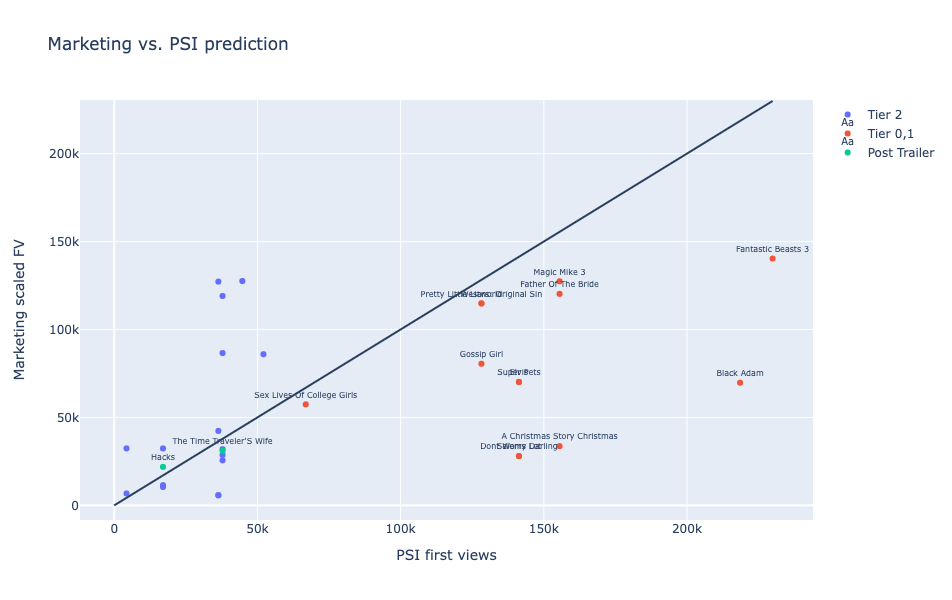

In [252]:

def get_pred_actual_plot(df_plt, df_plt_top, df_trailer, title, x, y):
    data = []

    data.append(go.Scatter(
                x=df_plt[x],
                y=df_plt[y],
                name='Tier 2',
                mode='markers',# + text',
                text= df_plt['title_name_x'].astype(str),
                textposition="top center"))
    data.append(go.Scatter(
                x=df_plt_top[x],
                y=df_plt_top[y],
                name='Tier 0,1',
                mode='markers + text',
                text= df_plt_top['title_name_x'].astype(str),
                textposition="top center"))
    data.append(go.Scatter(
                x=df_trailer[x],
                y=df_trailer[y],
                name='Post Trailer',
                mode='markers + text',
                text= df_trailer['title_name_x'].astype(str),
                textposition="top center"))
    
    py.offline.init_notebook_mode(connected=True) 
    
    fig = go.Figure(data=data)

    fig.update_traces(textfont_size=8)
    fig.update_layout(
        title=f'{title[0]}',
        xaxis_title= title[1],
        yaxis_title= title[2],
        width=600,
        height=600,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=0, y1= df_plt_top[x].max(),
            xref= 'x', x0=0, x1= df_plt_top[x].max())],
    showlegend=True)
    py.offline.iplot(fig)
    
    return fig

display(df_tot[df_tot.title_name_y.notnull() & df_tot.title_name_x.notnull()]\
[['title_name_x','imdb_id','season_number','effective_start_date','tier','category','trailer_date','first_views_mkt_scaled','first_views_psi']].sort_values(by='tier'))

display(df_tot[['title_name_x','tier','first_views_mkt_scaled','first_views_psi']][df_tot.title_name_x!='House Of The Dragon'].groupby(by='tier').sum())

filter_other = (df_tot.tier>1) & (df_tot.trailer_date.isnull())
filter_top= (df_tot.tier<=1) & (df_tot.trailer_date.isnull())
filter_trailer= (df_tot.trailer_date.notnull()) & (df_tot.title_name_x!='House Of The Dragon')


fig = get_pred_actual_plot(df_tot[filter_other], df_tot[filter_top], df_tot[filter_trailer],['Marketing vs. PSI prediction', 'PSI first views','Marketing scaled FV', ], 'first_views_psi', 'first_views_mkt_scaled',)


In [135]:
# display(df_psi.groupby('tier').count())
# display(df_tot.imdb_id.isnull().groupby(df_tot['tier']).sum().astype(int).reset_index(name='count'))
display(df_tot_raw[(df_tot_raw.title_name_x.isnull()) & (df_tot_raw.effective_start_date<'2023-01-01')].groupby(df_tot_raw['tier']).count())

,title_name_x,imdb_id,premiere_date,season_number,content_category_x,days_since_premiere,first_views,title_name_y,effective_start_date,tier,tier_adj,content_category_y,category,prequel_count,prequel_featured_count,pred_date,first_views_pred_decay
tier,,,,,,,,,,,,,,,,,
1.0,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1
2.0,0,29,0,29,0,0,0,29,29,29,29,29,29,29,29,29,29
3.0,0,80,0,80,0,0,0,80,80,80,80,80,80,80,80,80,80


In [ ]:
## Title total 
querystr = '''
select * 
from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
where effective_start_date>='2021-01-01' and effective_start_date<'2022-01-01'
'''

schedule='beta'

cursor_list = ctx.execute_string(
    querystr
    )
df_actual = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_actual.columns= df_actual.columns.str.lower()
df_actual.head(2)